##  Answering Business questions about Chinook Database using SQL

### Table of Contents
***
1 [GOAL](#definition)

1.1 [BUSINESS PROBLEMS](#problem)

2 [DISCOVER](#discover)

2.1 [Load](#loaddatabase)

2.2 [Key queries](#queries)

3 [Future Work](#futurework)

### 1: GOAL
<a id="definition"></a>

***
1. Explore the Chinook database using SQL and provide the store with some actionable insights on the outlined Business problems.

2. **Can we take an informed decision about the revenue indicators** 
     **and communicate to the business teams and come up with away effective strategies?**

3. *Source of the data* : https://github.com/lerocha/chinook-database/tree/master/ChinookDatabase/DataSources


### 1.1: BUSINESS PROBLEMS
<a id="problem"></a>

*Business Problem 1*: 

- Helping the Business team at Chinook to understand which Genres sell the most, in order to help the new deal with a record label. Focus Territory: USA

*Business Problem 2*: 

- Identify which employees are bringing in most revenue sales.

*Business Problem 3*: 

- Understand the track/album purchases from different countries.

 

### 2: DISCOVER
<a id="discover"></a>

This section consists of:

1. Connecting/loading the sqlite database connection (Creation/looking at the ERD diagram)

2. Looking at the different tables and views existing in the database

3. Creating specific queries/subqueries to anaswer the 3 key business questions


### 2.1: Load
<a id="loaddatabase"></a>

***
*ERD Diagram of the database* (Used Dbeaver to construct the ERD)

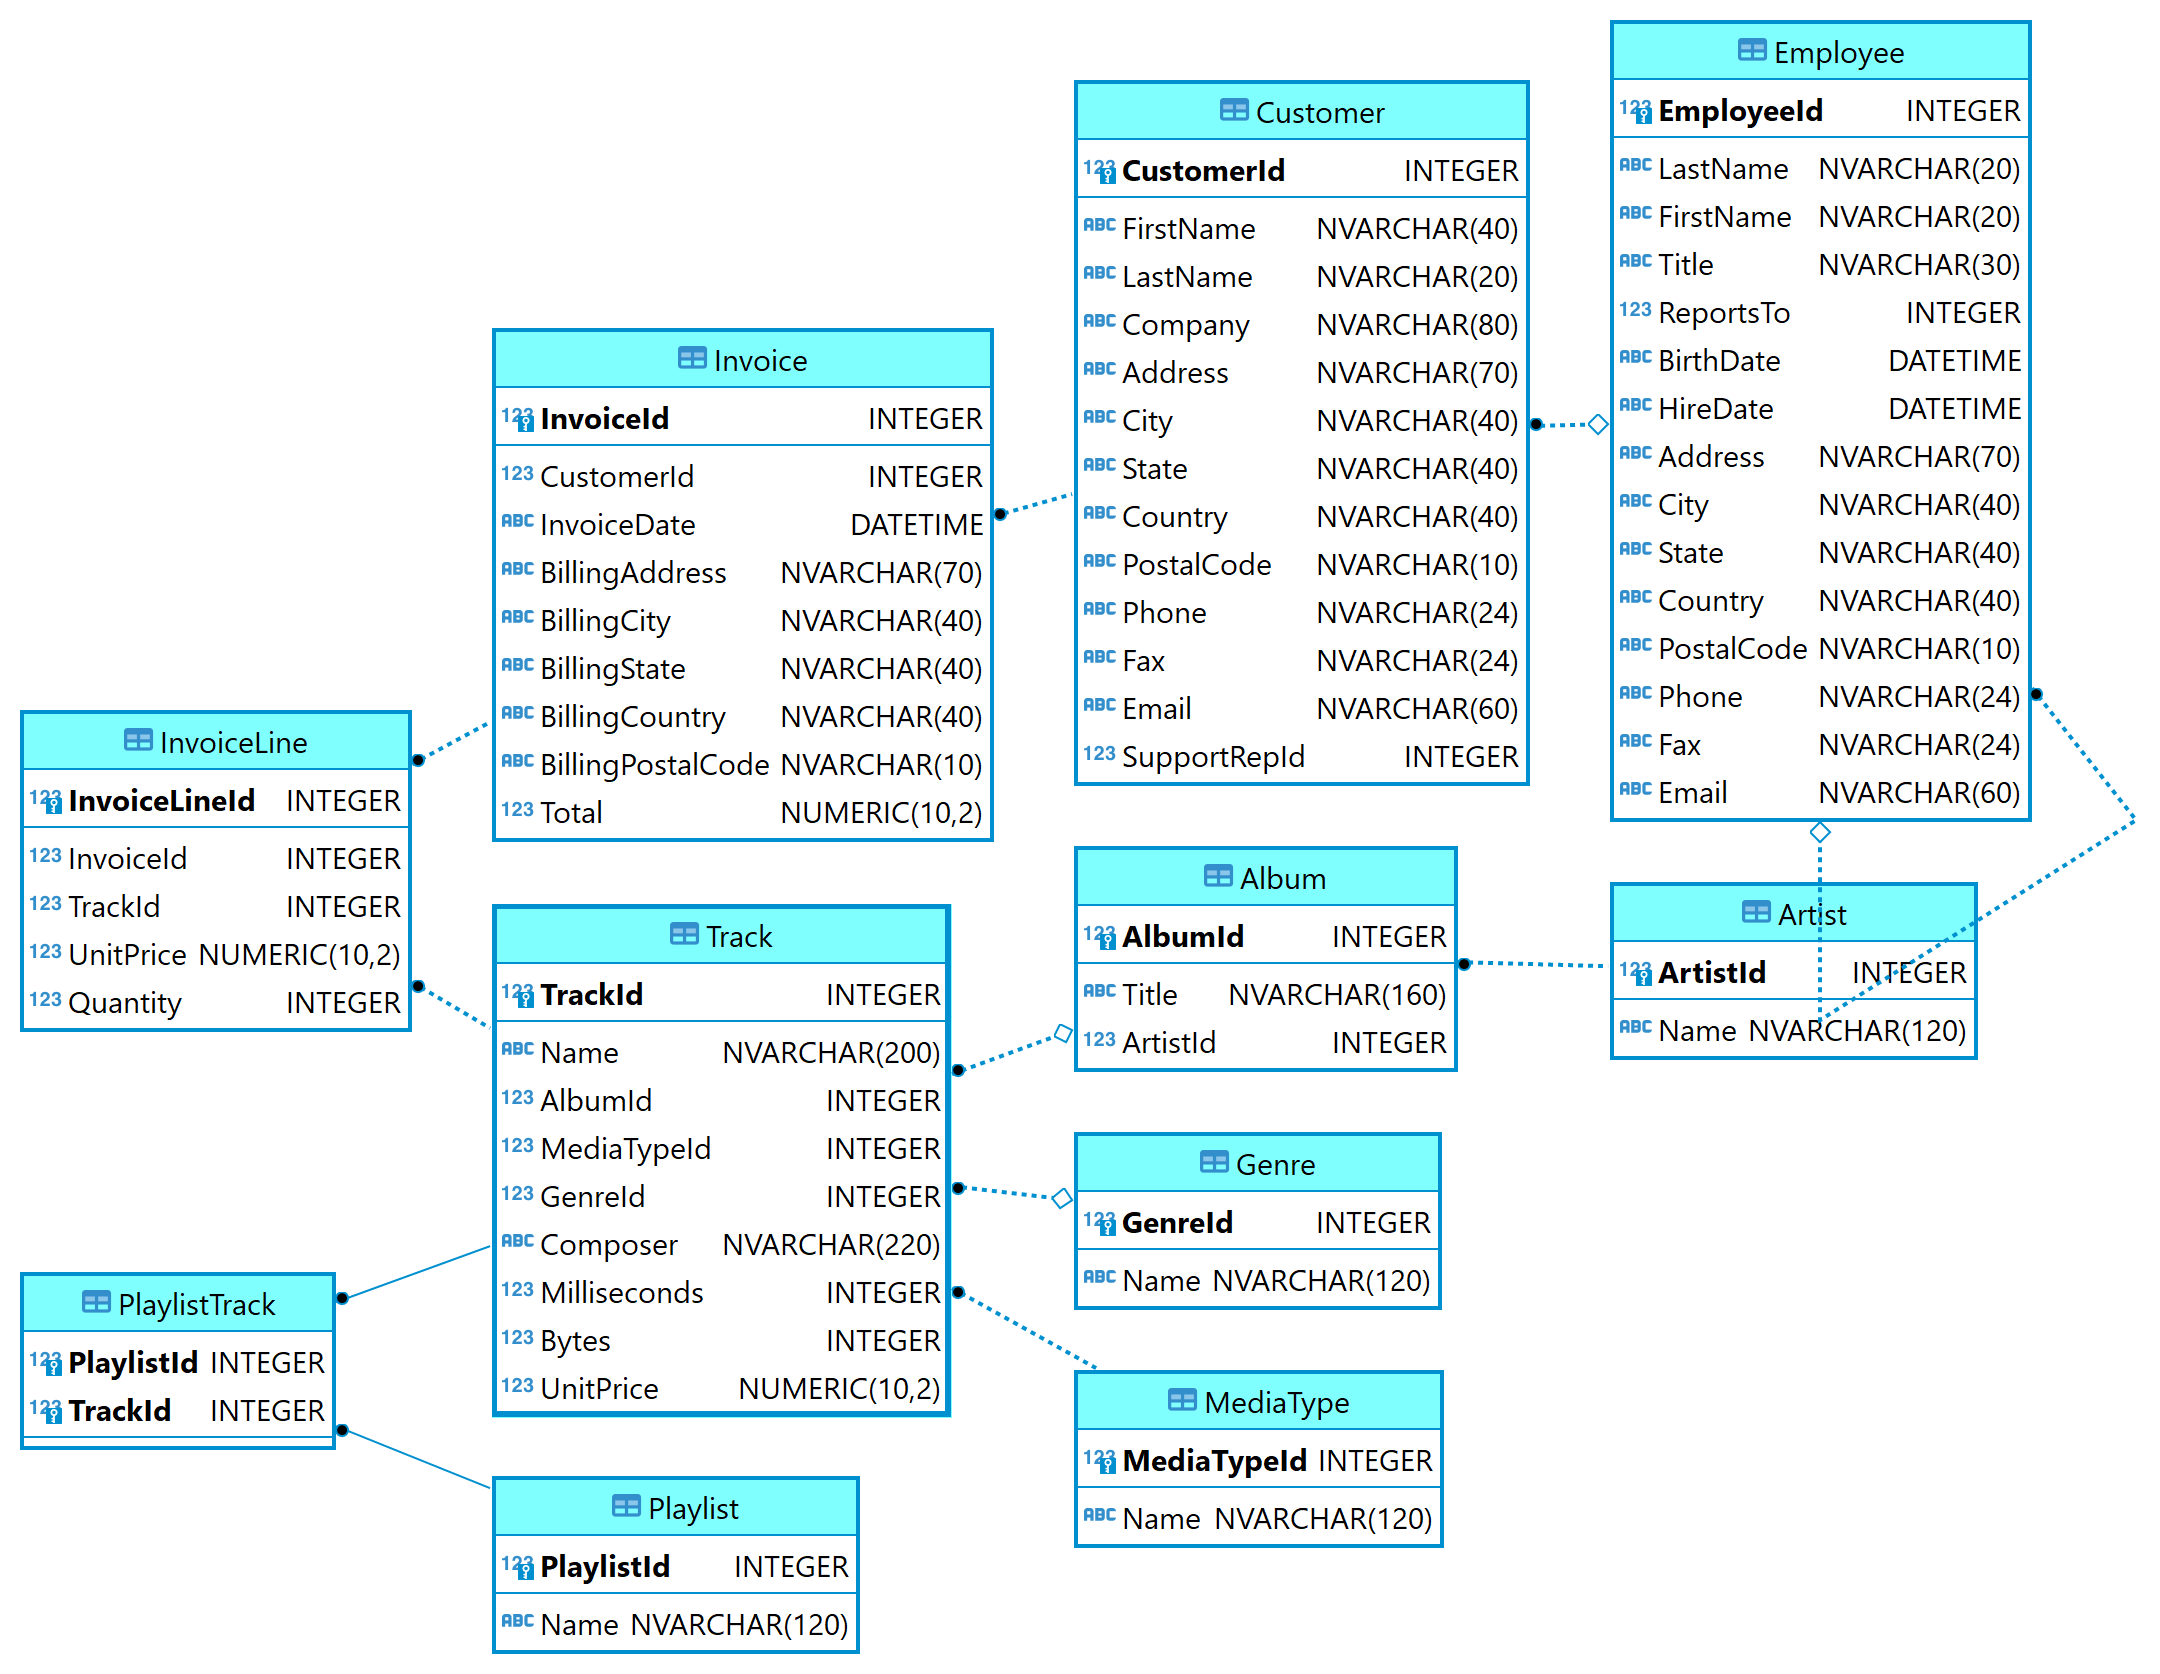!

In [1]:
%%capture
%load_ext sql
%sql sqlite:///Chinook_Sqlite.sqlite

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///Chinook_Sqlite.sqlite
Done.


name,type
Album,table
Artist,table
Customer,table
Employee,table
Genre,table
Invoice,table
InvoiceLine,table
MediaType,table
Playlist,table
PlaylistTrack,table


### 2.2: Key queries
<a id="queries"></a>


#### Business Problem 1: 

*Helping the Business team at Chinook to understand **which genres** sell the most, in order to help the new deal with a record label, **selecting the first three albums** that will be added to the store, from a **list of four genres**. Focus Territory: USA.*

The list of four albums to be analysed are:

|Artist      |Genre|
|------      |------  |
|Regal |Hip-Hop  |
|Red Tone  |Punk   |
|Meteor and the Girls | Pop
|Slim Jim Bites | Blues

In [3]:
%%sql
WITH inv_us AS (SELECT invoice.*, 
                InvoiceLine.*, 
                customer.*
                FROM InvoiceLine
                INNER JOIN Invoice
                ON InvoiceLine.InvoiceId = Invoice.InvoiceId
                INNER JOIN customer ON Invoice.CustomerId	 = customer.CustomerId	
                WHERE country LIKE 'USA')
,

inv_t AS       (SELECT track.*, 
                inv_us.*,
                genre.name AS genre_name
                FROM inv_us
                INNER JOIN track
                ON inv_us.TrackId = track.TrackId
                INNER JOIN genre
                ON genre.GenreId = track.GenreId
                )


SELECT genre_name, 
       COUNT(InvoiceLineId) As number_of_tracks_sold, 
       cast(round(cast(count(inv_t.InvoiceLineId) AS FLOAT) / (
        SELECT COUNT(*) from inv_t
        ),2)*100 As character varying) || '%'  AS percentage_of_tracks_sold
FROM inv_t
GROUP BY 1
ORDER BY 2 DESC
;

 * sqlite:///Chinook_Sqlite.sqlite
Done.


genre_name,number_of_tracks_sold,percentage_of_tracks_sold
Rock,157,32.0%
Latin,91,18.0%
Metal,64,13.0%
Alternative & Punk,50,10.0%
Jazz,22,4.0%
Blues,15,3.0%
TV Shows,14,3.0%
R&B/Soul,12,2.0%
Comedy,8,2.0%
Classical,8,2.0%


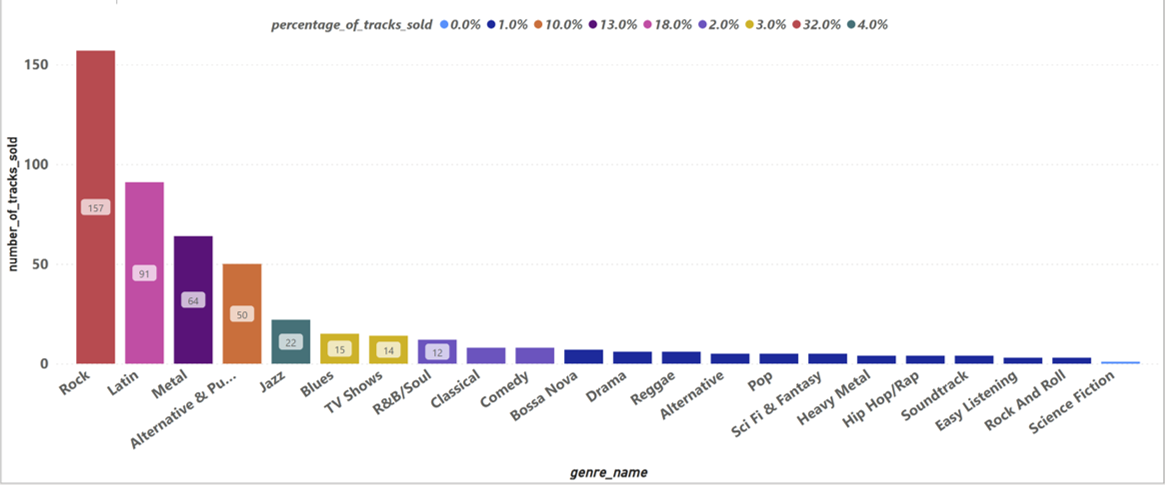

**Based on the above results, the first three albums that should be added to the store from the above list should be**:



|Artist 1       |Artist 2|Artist 3|
|------         |------  |------|
|Slim Jim Bites  |Meteor and the Girls  |Regal|
|Blues  |Pop     |Hip/Hop     |


 #### Business Problem 2: 
 
 *Identify which employees are bringing in most revenue sales.*

In [23]:
%%sql
WITH inv_employee AS (SELECT Invoice.*, 
                      invoiceLine.*, 
                      Customer.*,
                      Employee.FirstName AS employee_fname,
                      Employee.LastName AS employee_lname,
                      Employee.HireDate,
                      Employee.Title,
                      sum(Invoice.Total) As total
                      FROM InvoiceLine
                      INNER JOIN Invoice
                      ON InvoiceLine.InvoiceId = Invoice.InvoiceId
                      INNER JOIN Customer ON Invoice.CustomerId = Customer.CustomerId
                      INNER JOIN Employee ON Customer.SupportRepId = Employee.EmployeeId
                      GROUP BY 1,2,3,4,5,6)

--Select the names of the eployees leading towards highest sales
SELECT employee_fname || " " || employee_lname AS employee_name,
       Title,
       HireDate,
       round(SUM(total),2) AS total_sales
       FROM inv_employee
       GROUP BY 1

 * sqlite:///Chinook_Sqlite.sqlite
Done.


employee_name,Title,HireDate,total_sales
Jane Peacock,Sales Support Agent,2002-04-01 00:00:00,833.04
Margaret Park,Sales Support Agent,2003-05-03 00:00:00,775.4
Steve Johnson,Sales Support Agent,2003-10-17 00:00:00,720.16


**Jane Peacock leads the sales, 
  potentially because of the earlier hire date
  as compared to the other two employees.**


#### Business Problem 3: 

*Understand the track/album purchases from different countries.*


In [22]:
%%sql
WITH cust_country AS (SELECT Invoice.*, 
                      InvoiceLine.*, 
                      Customer.*
                      FROM InvoiceLine
                      INNER JOIN Invoice
                      ON InvoiceLine.InvoiceId = Invoice.InvoiceId
                      INNER JOIN customer ON Invoice.CustomerId = Customer.CustomerId
                      GROUP BY 1,2,3)
,

main_table AS
(
SELECT country, COUNT(DISTINCT(CustomerId)) AS number_of_customers, 
                SUM(total) AS total_value_sales,
                SUM(total)/COUNT(DISTINCT(CustomerId)) As average_sales_customers,
                AVG(total) AS average_order_value,
                CASE WHEN COUNT(DISTINCT(CustomerId)) = 1
                           THEN 0
                           ELSE 1
                      END AS sort_column
FROM cust_country

GROUP BY 1
ORDER BY total_value_sales DESC
)

SELECT 
      CASE WHEN sort_column = 1
           THEN Country
           ELSE "Other"
      END AS new_country_column,
      SUM(number_of_customers) As num_of_customers,
      ROUND(SUM(total_value_sales),2) AS total_sales,
      ROUND(AVG(average_sales_customers),2) AS average_sales_customer,
      ROUND(AVG(average_order_value),2) AS average_order
FROM main_table
GROUP BY new_country_column
ORDER BY total_value_sales DESC

 * sqlite:///Chinook_Sqlite.sqlite
Done.


new_country_column,num_of_customers,total_sales,average_sales_customer,average_order
USA,13,523.06,40.24,5.75
Canada,8,303.96,38.0,5.43
France,5,195.1,39.02,5.57
Brazil,5,190.1,38.02,5.43
Germany,4,156.48,39.12,5.59
United Kingdom,3,112.86,37.62,5.37
Czech Republic,2,90.24,45.12,6.45
Portugal,2,77.24,38.62,5.52
India,2,75.26,37.63,5.79
Other,15,604.3,40.29,5.76


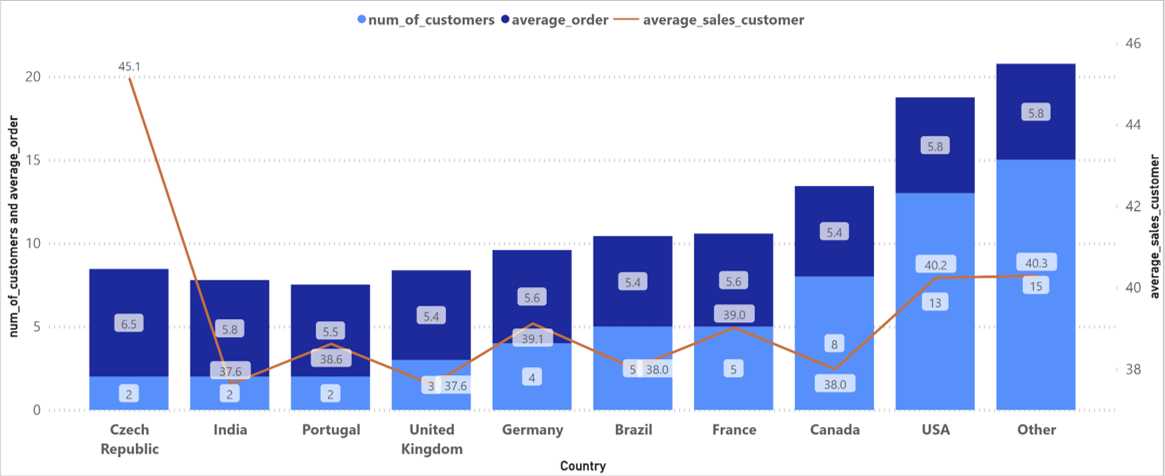

### 3: Future Work
<a id="futurework"></a>



Which artist is used in the most playlists?

How many tracks have been purchased vs not purchased?

Is the range of tracks in the store reflective of their sales popularity?

Do protected vs non-protected media types have an effect on popularity?